In [196]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon
import numpy as np
from PIL import Image, ImageDraw
from sklearn.decomposition import PCA, SparsePCA

cv2.setRNGSeed(42)

In [3]:
def filter1(image):
    image = cv2.medianBlur(image, 9)
    # image = cv2.GaussianBlur(image, (0, 0), 1)
    # image = cv2.fastNlMeansDenoisingColored(
    #     image, 
    #     h = 3,
    #     hColor = 5
    # )
    image = cv2.bilateralFilter(image, d=-1, sigmaColor=17, sigmaSpace=17)
    # image = cv2.bilateralFilter(image, 9, 3, 3)
    # image = cv2.bilateralFilter(image, 13, 6, 6)
    # image = cv2.filter2D(image, -1, np.array([
    #     [0, -1, 0],
    #     [-1, 5, -1],
    #     [0, -1, 0]
    # ]))
    return image

def filter2(image, median_size=3):
    image = cv2.medianBlur(image, median_size)
    image = cv2.bilateralFilter(image, 9, 75, 75)
    return image

def filter3(image, median_size=3):
    image = cv2.medianBlur(image, median_size)
    image = cv2.fastNlMeansDenoisingColored(image, hColor=10)
    return image

In [76]:
# Splits the given rect in 4 rect if there are at least k points inside 
def split_rect(rect, points, k=5, max_depth=5):
    # Rect is a tuple of 4 points
    # rect = (upper_right, upper_left, lower_left, lower_right)
    max_depth -= 1
    rects = []
    
    y_min, y_max = rect[3][1], rect[0][1]
    x_min, x_max = rect[1][0], rect[0][0]
    y_med, x_med = (y_max + y_min)/2, (x_max + x_min)/2
    
    inside_points = [p for p in points if p[0] >= x_min and p[0] <= x_max and p[1] >= y_min and p[1] <= y_max]
    if len(inside_points) == 0:
        return None
    
    if max_depth == 0:
        return []
    
    if len(inside_points) > k:
        upper_right_rect = ((x_max, y_max), (x_med, y_max), (x_med, y_med), (x_max, y_med))
        upper_left_rect = ((x_med, y_max), (x_min, y_max), (x_min, y_med), (x_med, y_med))
        lower_left_rect = ((x_med, y_med), (x_min, y_med), (x_min, y_min), (x_med, y_min))
        lower_right_rect = ((x_max, y_med), (x_med, y_med), (x_med, y_min), ((x_max, y_min)))
                
        upper_right_split = split_rect(upper_right_rect, points, k, max_depth)
        upper_left_split = split_rect(upper_left_rect, points, k, max_depth)
        lower_left_split = split_rect(lower_left_rect, points, k, max_depth)
        lower_right_split = split_rect(lower_right_rect, points, k, max_depth)
        
        if upper_right_split is not None:
            if len(upper_right_split) > 0:
                rects += upper_right_split
            else:
                rects += [upper_right_rect]
            
        if upper_left_split is not None:
            if len(upper_left_split) > 0:
                rects += upper_left_split
            else:
                rects += [upper_left_rect]
            
        if lower_left_split is not None:
            if len(lower_left_split) > 0:
                rects += lower_left_split
            else:
                rects += [lower_left_rect]
            
        if lower_right_split is not None:
            if len(lower_right_split) > 0:
                rects += lower_right_split
            else:
                rects += [lower_right_rect]
         
            
    return rects

def getDensity(matched_kp:list[tuple[float, float]], template_partition:list):
    match_count = { s: 0 for s in template_partition }
    
    for x_kp, y_kp in matched_kp:
        for section in template_partition:
            (x_max, y_max), (_, _), (x_min, y_min), (_, _) = section
            if (x_min <= x_kp <= x_max) and (y_min <= y_kp <= y_max):
                match_count[section] += 1

    return [s for s in template_partition if match_count[s] > 0]
    # return sum([1 for s in template_partition if match_count[s] > 0]) / len(template_partition)

---

In [121]:
tests_single = [
    ("./dataset/models/ref1.png", "./dataset/scenes/scene1.png"),
    ("./dataset/models/ref2.png", "./dataset/scenes/scene1.png"),
    ("./dataset/models/ref3.png", "./dataset/scenes/scene2.png"),
    ("./dataset/models/ref4.png", "./dataset/scenes/scene2.png"),
    ("./dataset/models/ref5.png", "./dataset/scenes/scene2.png"),
    ("./dataset/models/ref6.png", "./dataset/scenes/scene3.png"),
    ("./dataset/models/ref7.png", "./dataset/scenes/scene3.png"),
    ("./dataset/models/ref6.png", "./dataset/scenes/scene4.png"),
    ("./dataset/models/ref7.png", "./dataset/scenes/scene4.png"),
    ("./dataset/models/ref8.png", "./dataset/scenes/scene4.png"),
    ("./dataset/models/ref9.png", "./dataset/scenes/scene4.png"),
    ("./dataset/models/ref10.png", "./dataset/scenes/scene4.png"),
    ("./dataset/models/ref1.png", "./dataset/scenes/scene4.png"),
    ("./dataset/models/ref11.png", "./dataset/scenes/scene5.png"),
    ("./dataset/models/ref12.png", "./dataset/scenes/scene5.png"),
    ("./dataset/models/ref14.png", "./dataset/scenes/scene5.png"),
]
tests_multi = [
    ("./dataset/models/ref15.png", "./dataset/scenes/scene6.png"),
    ("./dataset/models/ref16.png", "./dataset/scenes/scene7.png"),
    ("./dataset/models/ref23.png", "./dataset/scenes/scene8.png"),
    ("./dataset/models/ref18.png", "./dataset/scenes/scene9.png"),
    ("./dataset/models/ref19.png", "./dataset/scenes/scene9.png"),
    ("./dataset/models/ref20.png", "./dataset/scenes/scene9.png"),
    ("./dataset/models/ref21.png", "./dataset/scenes/scene10.png"),
    ("./dataset/models/ref22.png", "./dataset/scenes/scene10.png"),
    ("./dataset/models/ref23.png", "./dataset/scenes/scene11.png"),
    ("./dataset/models/ref24.png", "./dataset/scenes/scene11.png"),
    ("./dataset/models/ref25.png", "./dataset/scenes/scene11.png"),
    ("./dataset/models/ref18.png", "./dataset/scenes/scene12.png"),
    ("./dataset/models/ref26.png", "./dataset/scenes/scene12.png"),
    ("./dataset/models/ref27.png", "./dataset/scenes/scene12.png")
]

tests  = tests_single + tests_multi

template_path, scene_path = tests_multi[-1]

template = cv2.imread(template_path)
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
# template = cv2.cvtColor(template, cv2.COLOR_RGB2HSV)[:,:,0].reshape(template.shape[0], template.shape[1], 1)

scene = cv2.imread(scene_path)
scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
# scene = cv2.cvtColor(scene, cv2.COLOR_RGB2HSV)[:,:,0]
# scene = filter1(scene).reshape(scene.shape[0], scene.shape[1], 1)

scene = filter1(scene)

In [147]:
def calculate_color_features(template, kp_template, window_size=5):
    # Padding on template
    padding = window_size // 2
    template = cv2.copyMakeBorder(template, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    # convert to hsv
    template = cv2.cvtColor(template, cv2.COLOR_RGB2HSV)
    
    res = np.array([
        np.mean(template[int(kp.pt[1]-padding):int(kp.pt[1]+padding), int(kp.pt[0]-padding):int(kp.pt[0]+padding)], axis=(0, 1))
        for kp in kp_template
    ], dtype=np.float32) / 255.0
    print(f"Color feature shape:{res.shape}")
    # return np.round(res, 0)
    return res

In [216]:
def polygonArea(points):
    x = np.array([ pt[0] for pt in points ])
    y = np.array([ pt[1] for pt in points ])
    return 0.5 * np.abs( (x @ np.roll(y,1)) - (y @ np.roll(x,1)) )

def getDensity(matched_kp:list[tuple[float, float]], template_partition:list):
    match_count = { s: 0 for s in template_partition }
    
    for x_kp, y_kp in matched_kp:
        for section in template_partition:
            (x_max, y_max), (_, _), (x_min, y_min), (_, _) = section
            if (x_min <= x_kp <= x_max) and (y_min <= y_kp <= y_max):
                match_count[section] += 1
                break

    return [s for s in template_partition if match_count[s] > 0]
    # return sum([1 for s in template_partition if match_count[s] > 0]) / len(template_partition)

def findInstances(
        scene, template, 
        to_try_thresholds = np.arange(0.7, 0.8, 0.05), 
        proj_overflow_tol = 200, 
        proj_min_area = 100,
        plot = False,
        density_threshold = 0.5
    ):
    cv2.setRNGSeed(42)

    sift = cv2.SIFT_create(
        contrastThreshold = 0.015,
        # contrastThreshold = 0.03,
        # edgeThreshold = 100000,
    )

    FLANN_INDEX_KDTREE = 1
    flann = cv2.FlannBasedMatcher(
        indexParams = { "algorithm": FLANN_INDEX_KDTREE, "trees": 5 },
        searchParams = { "checks": 1000 }
    )
    
    
    kp_template = sift.detect(template)
    kp_template, desc_template = sift.compute(template, kp_template)
    w, h, _ = template.shape
    splitted_template = split_rect(((h, w), (0, w), (0, 0), (h, 0) ),
                                   [(kp.pt[0], kp.pt[1]) for kp in kp_template],
                                   k=5,
                                   max_depth=4)
    
    ax = plt.subplot(1, 1, 1)
    ax.imshow(template)
    ax.plot([kp.pt[0] for kp in kp_template], [kp.pt[1] for kp in kp_template], "r.", markersize=3)
    for r in splitted_template:
        ax.add_patch(Rectangle(r[2], r[0][0] - r[1][0], r[0][1] - r[3][1], fill=False, color='purple', alpha=0.5))
    plt.show()

    curr_threshold_idx = 0
    found_objects = []

    while True:
        mult = 1000
        kp_template = sift.detect(template)
        kp_template, desc_template = sift.compute(template, kp_template)
        # desc_template = SparsePCA(n_components=127).fit_transform(desc_template)
        color_template = calculate_color_features(template, kp_template, window_size=11) * mult
        desc_template = np.concatenate((desc_template, color_template), axis=1)
        
        kp_scene = sift.detect(scene)
        kp_scene, desc_scene = sift.compute(scene, kp_scene)
        # desc_scene = SparsePCA(n_components=127).fit_transform(desc_scene)
        color_scene = calculate_color_features(scene, kp_scene, window_size=11) * mult
        desc_scene = np.concatenate((desc_scene, color_scene), axis=1) 
        
        
        print(f"Color scene:{color_scene.shape}\n Desc scene = {desc_scene.shape}")

        matches = flann.knnMatch(desc_template, desc_scene, k=2)
        good_matches = [ m for m, n in matches if m.distance < to_try_thresholds[curr_threshold_idx]*n.distance ]
        template_points = np.float32([ kp_template[m.queryIdx].pt for m in good_matches ]).reshape(-1, 2)
        scene_points = np.float32([ kp_scene[m.trainIdx].pt for m in good_matches ]).reshape(-1, 2)
            
        try:
            homography, mask = cv2.findHomography(template_points, scene_points, cv2.RANSAC , ransacReprojThreshold=20.0)
            print((mask>0).shape)
            mask = mask.reshape(-1,)
            
            if homography is None: raise Exception()
        except:
            curr_threshold_idx += 1
            if curr_threshold_idx >= len(to_try_thresholds): break
            continue
            
        h, w, _ = template.shape
        object_vertexes = cv2.perspectiveTransform(
            src = np.float32([ [0,0], [0,h-1], [w-1,h-1], [w-1,0] ]).reshape(-1, 1, 2), 
            m = homography
        )
        object_vertexes = [pt[0] for pt in object_vertexes]

        is_projection_valid = True

        # Check projected vertexes overflow
        for point in object_vertexes:
            if ((point[0] > scene.shape[1]+proj_overflow_tol) or (point[0] < -proj_overflow_tol) or 
                (point[1] > scene.shape[0]+proj_overflow_tol) or (point[1] < -proj_overflow_tol)): 
                is_projection_valid = False
                break
        
        # Check area of the detected polygon
        if polygonArea(object_vertexes) < proj_min_area:
            is_projection_valid = False

        if not is_projection_valid:
            curr_threshold_idx += 1
            if curr_threshold_idx >= len(to_try_thresholds): break
            continue


        # TODO: Check if found area is actually the template.
        """
            Possible idea:
            if number of matches < threshold:
                re-run kp detection on this portion of image

            maybe run knn again on the subset (it might be more precise)?

            density = check density with grid
            if density > threshold:
                match
            else:
                false positive
        """
        match_rects = getDensity(template_points[mask==1,:], splitted_template)

        if len(match_rects)/len(splitted_template) >= density_threshold:
            found_objects.append(object_vertexes)
            # plot
            ax = plt.subplot(1, 2, 1)
            ax.imshow(template)
            ax.plot([kp[0] for kp in template_points[mask==1,:]], [kp[1] for kp in template_points[mask==1,:]], "r.", markersize=3)
            for r in splitted_template:
                ax.add_patch(Rectangle(r[2], r[0][0] - r[1][0], r[0][1] - r[3][1], fill=True, alpha=0.2))
            for r in match_rects:
                ax.add_patch(Rectangle(r[2], r[0][0] - r[1][0], r[0][1] - r[3][1], fill=True, alpha=0.5))
            
            plt.subplot(1,2,2)
            plt.imshow(scene)
            plt.plot([kp[0] for kp in scene_points[mask==1]], [kp[1] for kp in scene_points[mask==1]], "r.", markersize=3)
            
            plt.show()
            
            # Mask the found area
            img_mask = Image.new('L', (scene.shape[1], scene.shape[0]), 0)
            ImageDraw.Draw(img_mask).polygon([
                (max(0, int(pt[0])), max(0, int(pt[1]))) for pt in object_vertexes
            ], outline=1, fill=1)
            mask = np.array(img_mask)
            
            scene[ mask == 1, : ] = 0
            
        else:
            ax = plt.subplot(1, 2, 1)
            ax.imshow(template)
            ax.plot([kp[0] for kp in template_points[mask==1,:]], [kp[1] for kp in template_points[mask==1,:]], "r.", markersize=3)
            for r in splitted_template:
                ax.add_patch(Rectangle(r[2], r[0][0] - r[1][0], r[0][1] - r[3][1], fill=True, alpha=0.2,color='green'))
            for r in match_rects:
                ax.add_patch(Rectangle(r[2], r[0][0] - r[1][0], r[0][1] - r[3][1], fill=True, alpha=0.5, color='green'))
            
            plt.subplot(1,2,2)
            plt.imshow(scene)
            plt.plot([kp[0] for kp in scene_points[mask==1]], [kp[1] for kp in scene_points[mask==1]], "r.", markersize=3)
            
            plt.show()
            print(f"False positive, {len(match_rects)/len(splitted_template)}")
            curr_threshold_idx += 1
            if curr_threshold_idx >= len(to_try_thresholds): break
            continue



        if plot:
            plt.figure(figsize=(10, 3))
            plt.suptitle(f"{to_try_thresholds[curr_threshold_idx]}")

            plt.subplot(1, 2, 1)
            plt.imshow(template)

            plt.subplot(1, 2, 2)
            plt.imshow(scene)
            plt.plot([kp[0] for kp in scene_points], [kp[1] for kp in scene_points], ".", markersize=8, markeredgewidth=1.5, markeredgecolor="black")
            plt.plot([pt[0] for pt in object_vertexes], [pt[1] for pt in object_vertexes], "x")

            plt.show()
        
    return found_objects

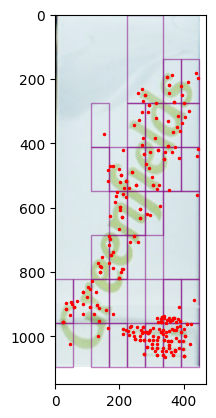

Color feature shape:(281, 3)
Color feature shape:(5130, 3)
Color scene:(5130, 3)
 Desc scene = (5130, 131)
(7, 1)
Color feature shape:(281, 3)
Color feature shape:(5130, 3)
Color scene:(5130, 3)
 Desc scene = (5130, 131)
(11, 1)
Color feature shape:(281, 3)
Color feature shape:(5130, 3)
Color scene:(5130, 3)
 Desc scene = (5130, 131)


error: OpenCV(4.8.1) d:\a\opencv-python\opencv-python\opencv\modules\flann\include\opencv2\flann\kdtree_index.h:468: error: (-215:Assertion failed) result.full() in function 'cvflann::KDTreeIndex<struct cvflann::L2<float> >::getNeighbors'


In [217]:
objects = findInstances(scene.copy(), template, plot=False, density_threshold=0.5)
plt.imshow( scene )
for obj_vertexes in objects:
    plt.gca().add_patch(Polygon(obj_vertexes, fill=True, alpha=0.5, color="red"))
plt.show()

./dataset/models/ref15.png ./dataset/scenes/scene6.png


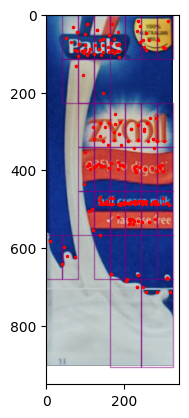

Color feature shape:(256, 3)
Color feature shape:(256, 3)
Color scene:(256, 3)
 Desc scene = (256, 131)
(13, 1)


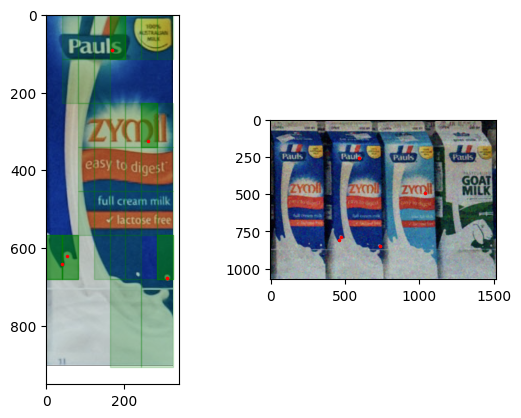

False positive, 0.1388888888888889
Color feature shape:(256, 3)
Color feature shape:(256, 3)
Color scene:(256, 3)
 Desc scene = (256, 131)
(17, 1)
Color feature shape:(256, 3)
Color feature shape:(256, 3)
Color scene:(256, 3)
 Desc scene = (256, 131)
(23, 1)
Color feature shape:(256, 3)
Color feature shape:(256, 3)
Color scene:(256, 3)
 Desc scene = (256, 131)
(37, 1)


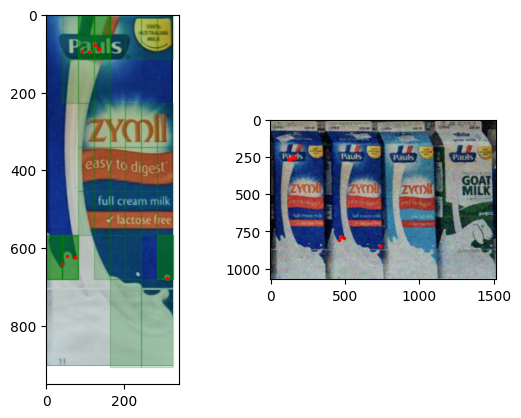

False positive, 0.1388888888888889
Color feature shape:(256, 3)
Color feature shape:(256, 3)
Color scene:(256, 3)
 Desc scene = (256, 131)
(60, 1)
Matches: 0


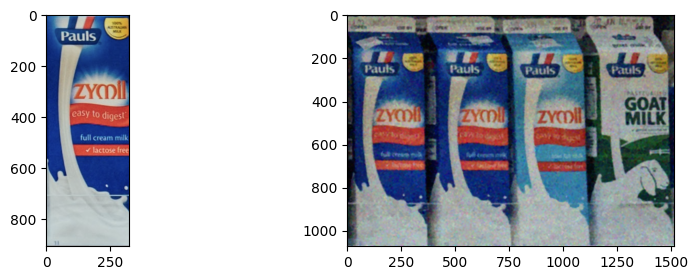

./dataset/models/ref16.png ./dataset/scenes/scene7.png


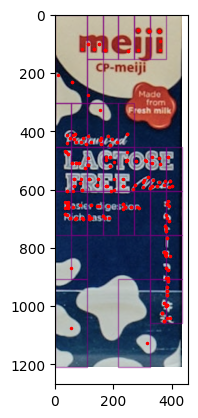

Color feature shape:(256, 3)
Color feature shape:(256, 3)
Color scene:(256, 3)
 Desc scene = (256, 131)
Color feature shape:(256, 3)
Color feature shape:(256, 3)
Color scene:(256, 3)
 Desc scene = (256, 131)
Color feature shape:(256, 3)
Color feature shape:(256, 3)
Color scene:(256, 3)
 Desc scene = (256, 131)
(7, 1)
Color feature shape:(256, 3)
Color feature shape:(256, 3)
Color scene:(256, 3)
 Desc scene = (256, 131)
(16, 1)


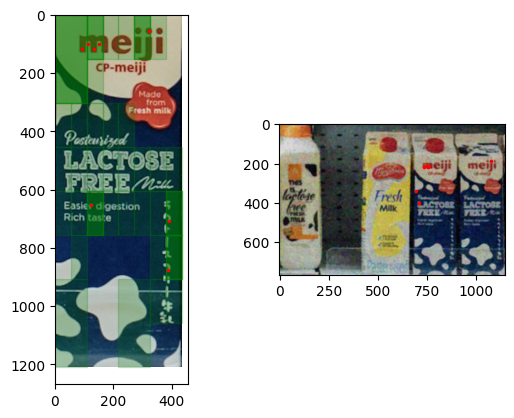

False positive, 0.17142857142857143
Color feature shape:(256, 3)
Color feature shape:(256, 3)
Color scene:(256, 3)
 Desc scene = (256, 131)
(49, 1)
Matches: 0


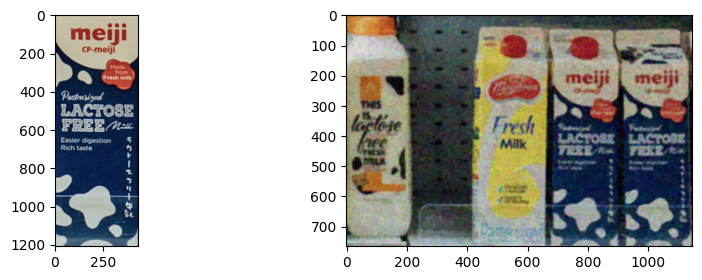

./dataset/models/ref23.png ./dataset/scenes/scene8.png


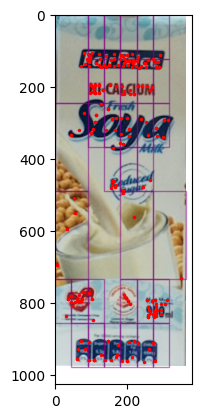

Color feature shape:(256, 3)
Color feature shape:(256, 3)
Color scene:(256, 3)
 Desc scene = (256, 131)
(19, 1)


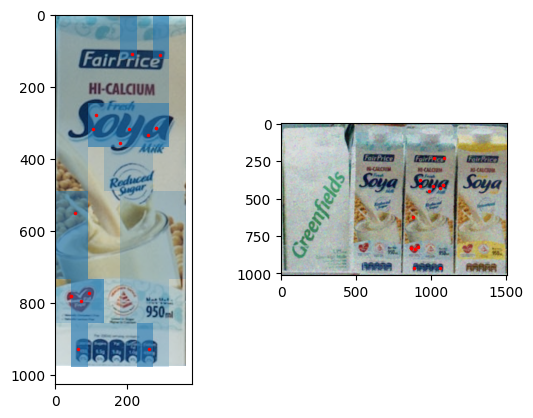

Color feature shape:(256, 3)
Color feature shape:(256, 3)
Color scene:(256, 3)
 Desc scene = (256, 131)
(13, 1)


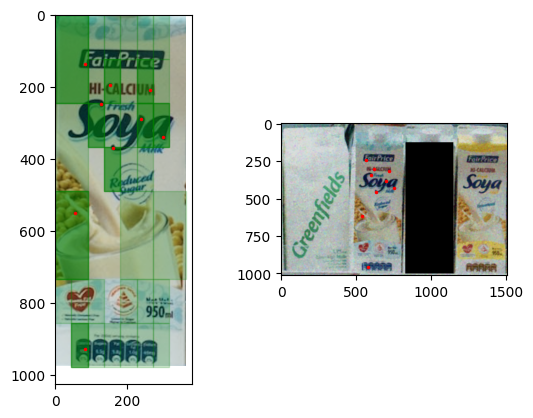

False positive, 0.2571428571428571
Color feature shape:(256, 3)
Color feature shape:(256, 3)
Color scene:(256, 3)
 Desc scene = (256, 131)
(21, 1)


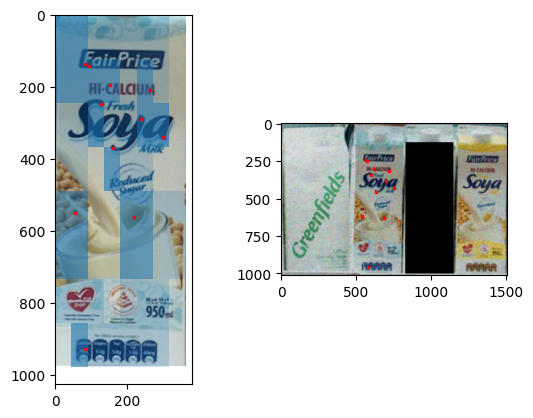

Color feature shape:(256, 3)
Color feature shape:(256, 3)
Color scene:(256, 3)
 Desc scene = (256, 131)
(29, 1)


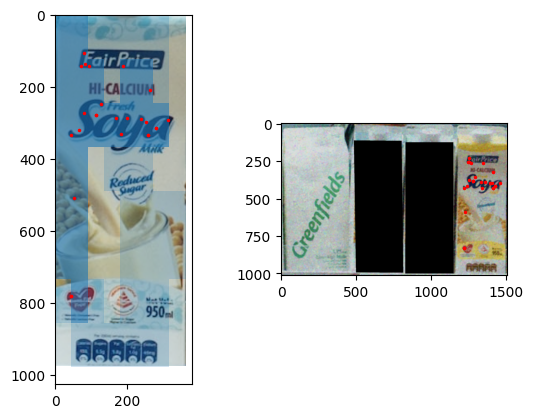

Color feature shape:(256, 3)
Color feature shape:(256, 3)
Color scene:(256, 3)
 Desc scene = (256, 131)
Color feature shape:(256, 3)
Color feature shape:(256, 3)
Color scene:(256, 3)
 Desc scene = (256, 131)
(5, 1)


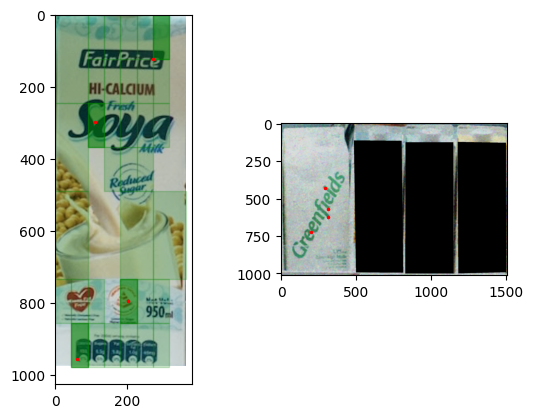

False positive, 0.11428571428571428
Color feature shape:(256, 3)
Color feature shape:(256, 3)
Color scene:(256, 3)
 Desc scene = (256, 131)
(14, 1)


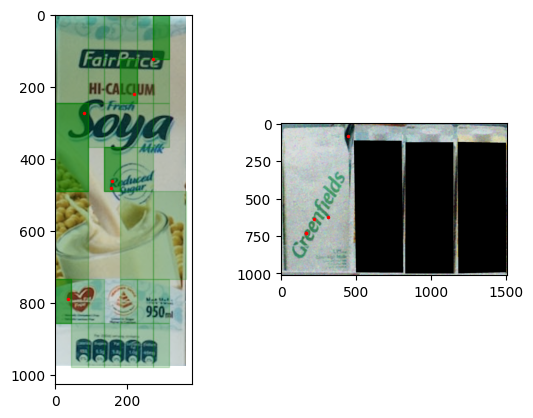

False positive, 0.14285714285714285
Color feature shape:(256, 3)
Color feature shape:(256, 3)
Color scene:(256, 3)
 Desc scene = (256, 131)
(39, 1)


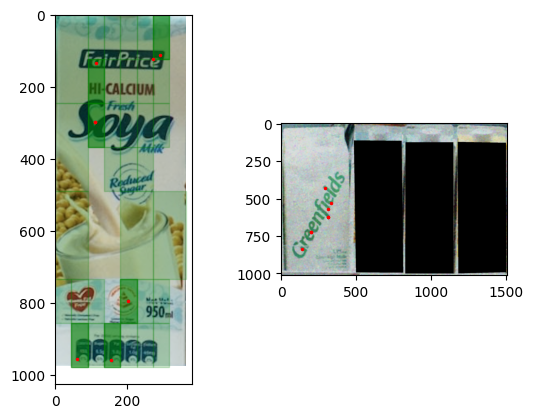

False positive, 0.17142857142857143
Matches: 3


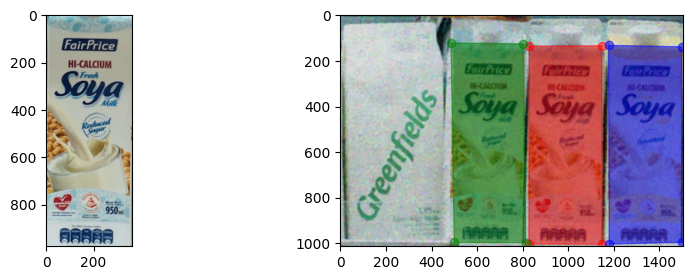

./dataset/models/ref18.png ./dataset/scenes/scene9.png


KeyboardInterrupt: 

In [ ]:
colors = ["red", "green", "blue", "cyan", "magenta", "yellow", "black", "white"]

for template_path, scene_path in tests_multi:#tests[:10]:
    print(template_path, scene_path)
    
    template = cv2.imread(template_path)
    template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
    scene = cv2.imread(scene_path)
    scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
    scene = filter1(scene)

    objects = findInstances(
        scene.copy(), template,
        to_try_thresholds = np.arange(0.7, 0.9, 0.05),  
        plot = False,
        proj_min_area = 1500,
        density_threshold=0.3
    )
    print(f"Matches: {len(objects)}")

    plt.figure(figsize=(10, 3))

    plt.subplot(1, 2, 1)
    plt.imshow( template )

    plt.subplot(1, 2, 2)
    plt.imshow( scene )
    for i, obj_vertexes in enumerate(objects):
        plt.gca().add_patch(Polygon(obj_vertexes, fill=True, alpha=0.5, color=colors[i % len(colors)]))
        plt.plot([pt[0] for pt in obj_vertexes], [pt[1] for pt in obj_vertexes], "o", alpha=0.5, color=colors[i % len(colors)])

    plt.show()


![Hello World]( 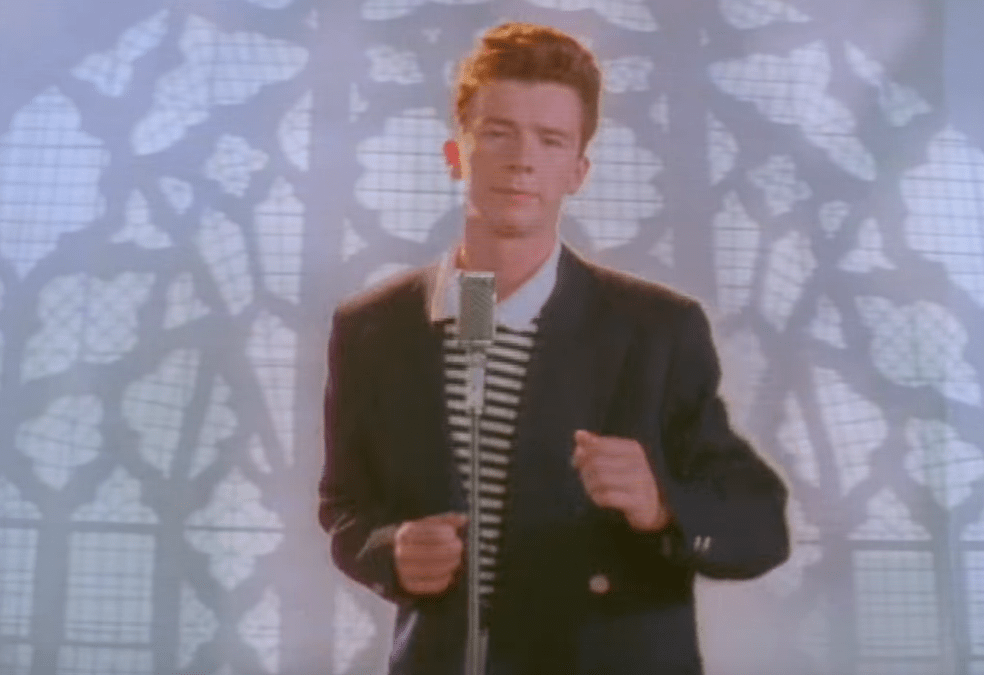)